# Setup and load in the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data (replace 'file.csv' with your actual file path)
complete_df = pd.read_csv('Resources/cleaned_completed_data.csv')

# Convert 'Date' column to datetime format
complete_df['date'] = pd.to_datetime(complete_df['date'], errors='coerce')

# Display the results
complete_df.head()

,date,index_sa,redfin_hpi_mom,case_shiller_index_mom,period_duration,region_type,table_id,is_seasonally_adjusted,region,state,...,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,30_year_%,price_drops_is_blank,price_drops_mom_is_blank,price_drops_yoy_is_blank
0,2012-01-01,59.9,0.0,-0.000005,30,state,23,False,Oklahoma,Oklahoma,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
1,2012-01-01,59.9,0.0,-0.000005,30,state,10,False,New Hampshire,New Hampshire,...,0.000000,0.000000,0.0,0.007093,0.000006,-0.000002,3.915,True,True,True
2,2012-01-01,59.9,0.0,-0.000005,30,state,42,False,Virginia,Virginia,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
3,2012-01-01,59.9,0.0,-0.000005,30,state,47,False,Michigan,Michigan,...,0.000000,0.000000,0.0,0.013045,-0.000005,0.000007,3.915,True,True,True
4,2012-01-01,59.9,0.0,-0.000005,30,state,12,False,New Jersey,New Jersey,...,0.000549,0.000005,0.0,0.007897,0.000018,0.000061,3.915,False,False,True


In [3]:
# Extract the year and calculate yearly averages
yearly_avg = complete_df.groupby(complete_df['date'].dt.year)['median_list_price'].mean().reset_index()

# Rename columns for clarity
yearly_avg.columns = ['Year', 'Median List Price']

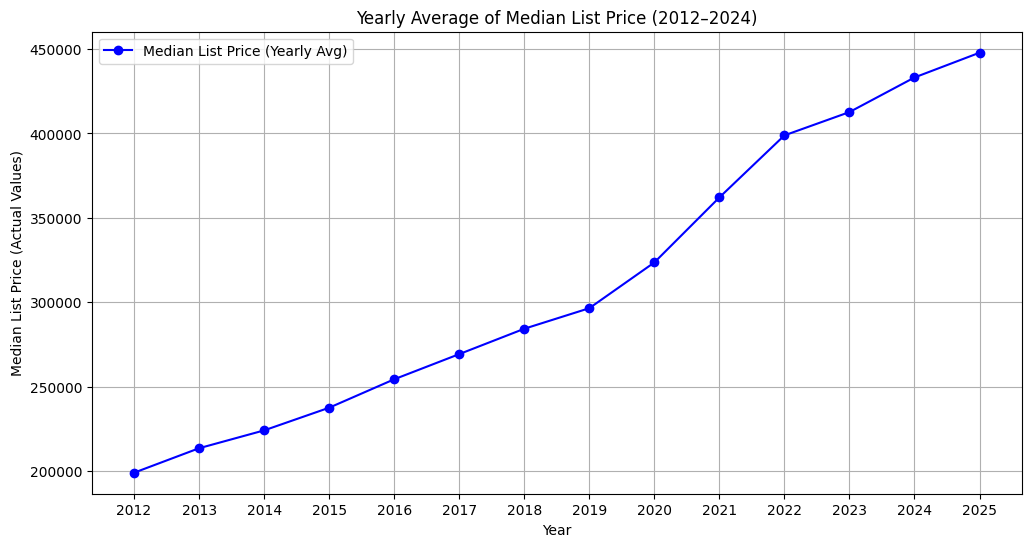

In [4]:
# Plot yearly averages of median_list_price
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg['Year'], yearly_avg['Median List Price'], marker='o', color='blue', label='Median List Price (Yearly Avg)')

# Customize the chart
plt.xlabel('Year')
plt.ylabel('Median List Price (Actual Values)')
plt.title('Yearly Average of Median List Price (2012–2024)')
plt.legend()
plt.grid(True)

# Set xticks to include every year in the range
plt.xticks(yearly_avg['Year'])

# Show the plot
plt.show()

In [5]:
# Convert categorical columns using one-hot encoding
complete_df = pd.get_dummies(complete_df, columns=['region_type', 'is_seasonally_adjusted', 
                                                   'region', 'state', 'property_type'], drop_first=True)

In [6]:
# Select numeric columns from the DataFrame
numeric_df = complete_df.select_dtypes(include=[np.number])

# Show the min and max values for all columns
for col in numeric_df.columns:
    print(f"{col}: Min = {numeric_df[col].min()}, Max = {numeric_df[col].max()}")

index_sa: Min = 59.9, Max = 172.1
redfin_hpi_mom: Min = -0.0012, Max = 0.019
case_shiller_index_mom: Min = -6.97e-05, Max = 0.000189
period_duration: Min = 30, Max = 30
table_id: Min = 1, Max = 51
median_sale_price: Min = 7000, Max = 3275000
median_sale_price_mom: Min = -0.00913, Max = 0.2215270935960591
median_sale_price_yoy: Min = -0.0094134677419354, Max = 0.1257142857142857
median_list_price: Min = 53000.0, Max = 4700000.0
median_list_price_mom: Min = -0.0074388387547208, Max = 0.0357864417134923
median_list_price_yoy: Min = -0.0072507525002704, Max = 0.0363052617609819
median_ppsf: Min = 3.0, Max = 40906.0
median_ppsf_mom: Min = -0.0099740143148445, Max = 3.12172894350185
median_ppsf_yoy: Min = -0.0099760368452768, Max = 2.4325566423457765
median_list_ppsf: Min = 27.0, Max = 1873.0
median_list_ppsf_mom: Min = -0.0095540224646076, Max = 0.201536630306659
median_list_ppsf_yoy: Min = -0.0094918034612375, Max = 0.2102027881762564
homes_sold: Min = 1, Max = 53605
homes_sold_mom: Min = 

In [5]:
# Fill any missing values with the mean
complete_df = complete_df.fillna(complete_df.mean())

# Confirm completed
complete_df.isnull().sum()

date                                       0
index_sa                                   0
redfin_hpi_mom                             0
case_shiller_index_mom                     0
period_duration                            0
                                          ..
state_Wyoming                              0
property_type_Condo/Co-op                  0
property_type_Multi-Family (2-4 Unit)      0
property_type_Single Family Residential    0
property_type_Townhouse                    0
Length: 156, dtype: int64

## Preprocessing

In [7]:
# Inspect 'median_ppsf' due to large range

# Define bins in increments of $0–75
bins = np.arange(0, numeric_df['median_ppsf'].max() + 75, 75)
labels = [f"${int(b)}-${int(b + 75)}" for b in bins[:-1]]

# Bin the 'median_ppsf' column
numeric_df['median_ppsf_bin'] = pd.cut(numeric_df['median_ppsf'], bins=bins, labels=labels, include_lowest=True)

# Count the occurrences in each bin
bin_counts = numeric_df['median_ppsf_bin'].value_counts().sort_index()

# Display the counts
bin_counts.head(25)

median_ppsf_bin
$0-$75          3668
$75-$150       18662
$150-$225       9250
$225-$300       3680
$300-$375       1449
$375-$450        974
$450-$525        635
$525-$600        357
$600-$675        133
$675-$750        112
$750-$825         44
$825-$900         16
$900-$975         10
$975-$1050        14
$1050-$1125        7
$1125-$1200       11
$1200-$1275        2
$1275-$1350        4
$1350-$1425        7
$1425-$1500        3
$1500-$1575        0
$1575-$1650        2
$1650-$1725        1
$1725-$1800        0
$1800-$1875        1
Name: count, dtype: int64

In [8]:
# Taking the bin_counts find the highest 25 'median_ppsf' values

# Sort the median_ppsf column in descending order and find the top 5 highest values
top_25_values = numeric_df['median_ppsf'].sort_values(ascending=False).head(25)

print("Highest 25 median_ppsf values:")
top_25_values

Highest 25 median_ppsf values:


38340    40906.0
8121     25964.0
6345     12690.0
16296     7214.0
21969     3790.0
3339      3672.0
1774      3140.0
19507     2712.0
31140     2504.0
14506     1996.0
16246     1957.0
9459      1918.0
3260      1839.0
22422     1720.0
8381      1645.0
16531     1576.0
2679      1468.0
17529     1463.0
2825      1457.0
6147      1409.0
29086     1406.0
15701     1395.0
3311      1393.0
9820      1375.0
22875     1371.0
Name: median_ppsf, dtype: float64

In [9]:
# Define bins for $100k increments
bins = np.arange(0, numeric_df['median_list_price'].max() + 100000, 100000)
labels = [f"${int(b)}-${int(b + 100000)}" for b in bins[:-1]]

# Bin the 'median_list_price' column
numeric_df['median_list_price_bin'] = pd.cut(numeric_df['median_list_price'], bins=bins, labels=labels, include_lowest=True)

# Count the occurrences in each bin
list_price_bin_counts = numeric_df['median_list_price_bin'].value_counts().sort_index()

# Display the counts
list_price_bin_counts

median_list_price_bin
$0-$100000              77
$100000-$200000       9697
$200000-$300000      14605
$300000-$400000       6954
$400000-$500000       3679
$500000-$600000       2118
$600000-$700000       1014
$700000-$800000        477
$800000-$900000        216
$900000-$1000000       104
$1000000-$1100000       27
$1100000-$1200000       16
$1200000-$1300000        7
$1300000-$1400000        5
$1400000-$1500000        1
$1500000-$1600000       10
$1600000-$1700000        4
$1700000-$1800000        2
$1800000-$1900000        2
$1900000-$2000000        7
$2000000-$2100000        4
$2100000-$2200000        5
$2200000-$2300000        4
$2300000-$2400000        5
$2400000-$2500000        1
$2500000-$2600000        4
$2600000-$2700000        1
$2700000-$2800000        0
$2800000-$2900000        2
$2900000-$3000000        2
$3000000-$3100000        1
$3100000-$3200000        0
$3200000-$3300000        1
$3300000-$3400000        0
$3400000-$3500000        0
$3500000-$3600000        0
$36000

In [10]:
# Set pandas to display floats as regular notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Define limits
upper_limit_price = 1500000  
upper_limit_dom = 730        

# Apply filters to remove rows with outliers
filtered_df = complete_df[
    (complete_df['median_list_price'] <= upper_limit_price) & 
    (complete_df['median_dom'] <= upper_limit_dom)
]

# Verify the changes
print(filtered_df[['median_list_price', 'median_dom']].describe())

       median_list_price  median_dom
count           38921.00    38921.00
mean           301255.51       71.08
std            146296.45       52.17
min             53000.00        0.00
25%            200000.00       38.00
50%            260300.00       59.00
75%            362400.00       90.00
max           1491600.00      727.00


In [11]:
# Engineer interaction features
complete_df['price_per_sqft_ratio'] = complete_df['median_sale_price'] / complete_df['median_ppsf']
complete_df['inventory_to_sales_ratio'] = complete_df['inventory'] / complete_df['homes_sold']

# Handle cases where division might result in NaN or infinite values
complete_df['price_per_sqft_ratio'] = complete_df['price_per_sqft_ratio'].fillna(0).replace(np.inf, 0)
complete_df['inventory_to_sales_ratio'] = complete_df['inventory_to_sales_ratio'].fillna(0).replace(np.inf, 0)

## Split the data into training (1/1/2014 - 2/28/2013) and testing sets (3/1/23 - 9/30/2024) and define our target. `median_sales_price`.

In [12]:
# Split the dataset into training and testing sets based on the Date column
train_data = complete_df[(complete_df['date'] >= '2013-01-01') & (complete_df['date'] <= '2023-2-28')]
test_data = complete_df[(complete_df['date'] >= '2023-03-01') & (complete_df['date'] <= '2024-09-30')]

# Check the split
print(f"Training data: {len(train_data)} rows")
print(f"Testing data: {len(test_data)} rows")

Training data: 30265 rows
Testing data: 4760 rows


In [13]:
# Drop redundant columns
columns_to_drop = ['case_shiller_index_mom', 'period_duration', 'table_id']  

# Define the train and test data
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [14]:
# Define the target variable (y)
y_train = train_data['median_sale_price']
y_test = test_data['median_sale_price']

# Define the features (X) by dropping only the target column 
X_train = train_data.drop(columns=['median_sale_price'])
X_test = test_data.drop(columns=['median_sale_price'])

print(X_train.columns == X_test.columns)  

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


In [15]:
# Extract the date and target columns from the test data
test_target_with_date = test_data[['date', 'median_sale_price']]

# Save it to a CSV file
test_target_with_date.to_csv('Resources/target_data.csv', index=False)

print("Target set with date saved successfully!")

Target set with date saved successfully!


In [16]:
# load in the 'rf_optimized_1_results.csv'
test_results = pd.read_csv('Resources/rf_optimized_1_results.csv')

# Display results
test_results.head()

,Actual,Predicted,Difference
0,353000,354822.00,-1822.00
1,371400,371841.56,-441.56
2,243700,243554.42,145.58
3,612500,610418.00,2082.00
4,358700,358263.73,436.27


In [17]:
# Drop the 'median_sale_price' column from 'test_target_with_date'
test_target_with_date = test_target_with_date.drop(columns=['median_sale_price'])

# Merge 'test_target_with_date' with 'test_results' 
merged_results = pd.concat([test_target_with_date.reset_index(drop=True), test_results.reset_index(drop=True)], axis=1)

# Save the merged results to a CSV for further analysis or plotting
merged_results.to_csv('Resources/rf_test_results.csv', index=False)

print("Merged results saved successfully!")

Merged results saved successfully!


In [18]:
# Count the number of rows for each date
date_counts = merged_results['date'].value_counts().sort_index()

# Print the counts for each date
date_counts

date
2023-03-01    251
2023-04-01    250
2023-05-01    250
2023-06-01    252
2023-07-01    252
2023-08-01    252
2023-09-01    251
2023-10-01    253
2023-11-01    252
2023-12-01    251
2024-01-01    251
2024-02-01    250
2024-03-01    250
2024-04-01    248
2024-05-01    250
2024-06-01    250
2024-07-01    248
2024-08-01    248
2024-09-01    251
Name: count, dtype: int64

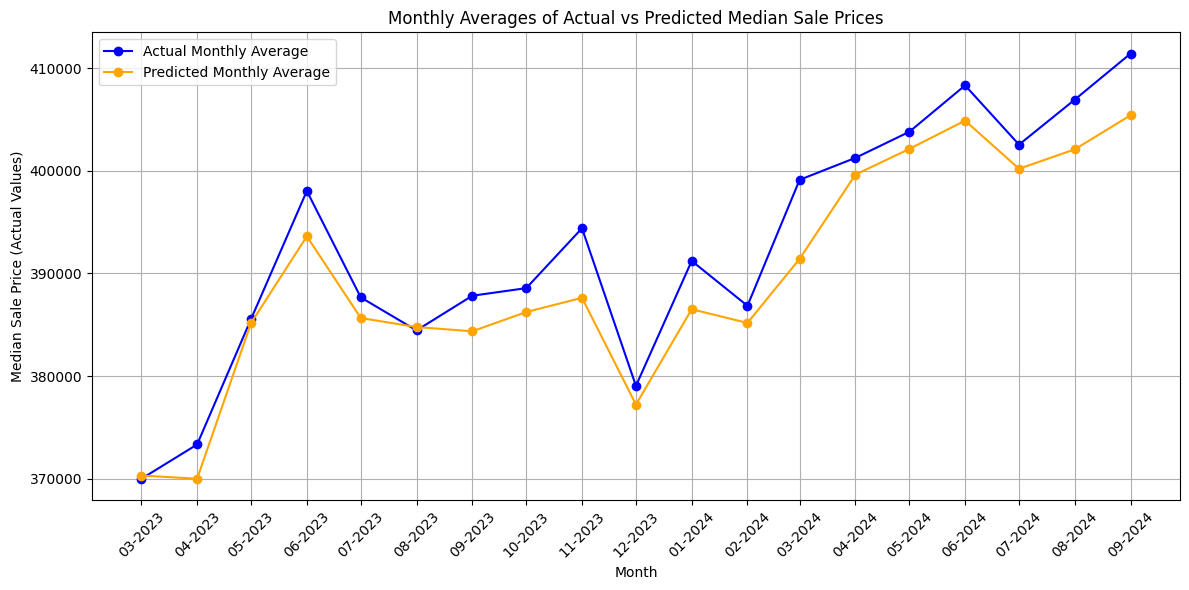

Plot saved as 'Resources/test_results_plot.png'.


In [19]:
# Ensure the 'date' column is in datetime format
merged_results['date'] = pd.to_datetime(merged_results['date'])

# Group by month and calculate the average for Actual and Predicted
monthly_avg = merged_results.groupby(merged_results['date'].dt.to_period('M')).mean()

# Convert the Period Index back to datetime for plotting
monthly_avg.index = monthly_avg.index.to_timestamp()

# Plot the monthly averages
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg['Actual'], label='Actual Monthly Average', marker='o', color='blue')
plt.plot(monthly_avg.index, monthly_avg['Predicted'], label='Predicted Monthly Average', marker='o', color='orange')

# Add titles and labels
plt.title('Monthly Averages of Actual vs Predicted Median Sale Prices')
plt.xlabel('Month')
plt.ylabel('Median Sale Price (Actual Values)')
plt.legend()
plt.grid()

# Set xticks to include all measured dates
plt.xticks(monthly_avg.index, monthly_avg.index.strftime('%m-%Y'), rotation=45)

# Save the plot as an image
plt.savefig('Resources/test_results_plot.png', format='png', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

print("Plot saved as 'Resources/test_results_plot.png'.")

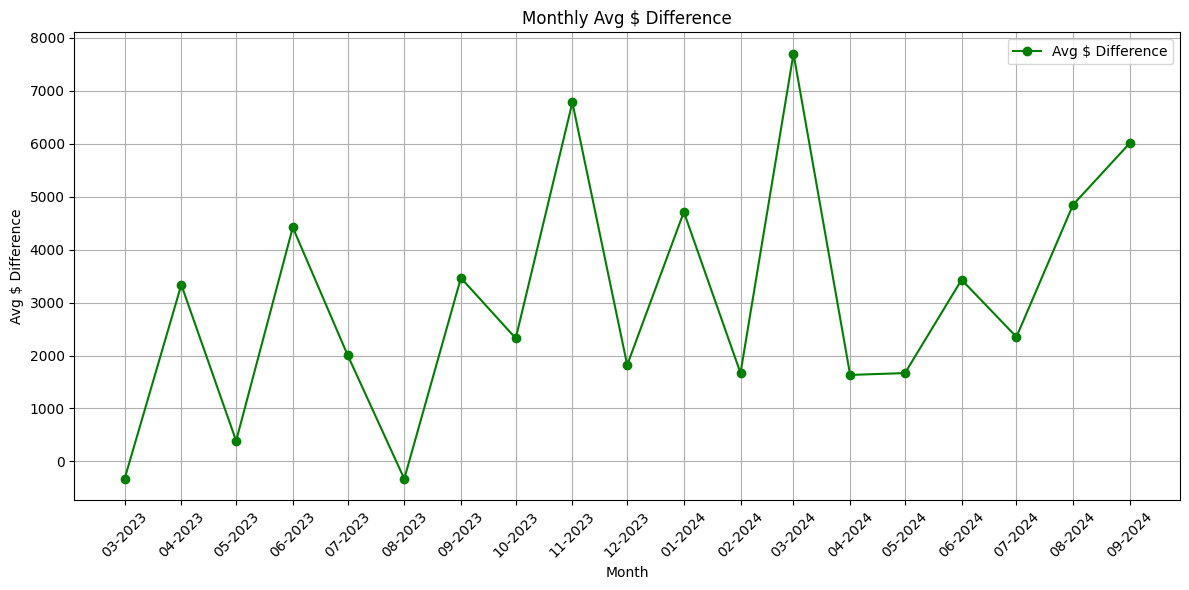

Plot saved as 'Resources/monthly_difference_plot.png'.


In [20]:
# Group by month and calculate the average Difference
monthly_difference_avg = merged_results.groupby(merged_results['date'].dt.to_period('M'))['Difference'].mean()

# Convert the PeriodIndex back to datetime for plotting
monthly_difference_avg.index = monthly_difference_avg.index.to_timestamp()

# Plot the monthly averages of Difference
plt.figure(figsize=(12, 6))
plt.plot(monthly_difference_avg.index, monthly_difference_avg, label='Avg $ Difference', marker='o', color='green')

# Add titles and labels
plt.title('Monthly Avg $ Difference')
plt.xlabel('Month')
plt.ylabel('Avg $ Difference')
plt.grid()
plt.xticks(monthly_difference_avg.index, monthly_difference_avg.index.strftime('%m-%Y'), rotation=45)
plt.legend()

# Save the plot as a PNG
plt.tight_layout()
plt.savefig('Resources/monthly_difference_plot.png', format='png', dpi=300)

# Show the plot
plt.show()

print("Plot saved as 'Resources/monthly_difference_plot.png'.")


## Load in the saved `final_rf_model` and re-run on the training and testing data set and make predictions for future years.

In [21]:
from joblib import load

# Load the model 'rf_optimized_1.ipynb' 
loaded_model = load('Resources/final_rf_model.joblib')

print("Model loaded successfully!")

Model loaded successfully!


In [22]:
print(loaded_model)

RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)


In [38]:
# Create the New y_test data to run full train + test on
# Ensure 'date' is in datetime format
complete_df['date'] = pd.to_datetime(complete_df['date'])

# Extract the year from the 'date' column
complete_df['year'] = complete_df['date'].dt.year

# Filter data for the year 2024
data_2024 = complete_df[complete_df['year'] == 2024]

# Define DataFrames for mean_time and recent_time, initializing with one row
mean_time = pd.DataFrame(index=[0])
recent_time = pd.DataFrame(index=[0])

# List of Top 25 features
top_25_features = [
       'median_list_price', 'price_per_sqft_ratio', 'median_list_ppsf',
       'median_ppsf', 'median_sale_price_yoy', 'index_sa',
       'median_sale_price_mom', 'pending_sales', 'property_type_Condo/Co-op',
       'inventory', 'median_ppsf_yoy', 'inventory_yoy', 'inventory_mom',
       'median_ppsf_mom', 'avg_sale_to_list', 'new_listings', 'homes_sold',
       'avg_sale_to_list_yoy', 'pending_sales_mom', 'homes_sold_mom',
       'median_dom', 'new_listings_yoy', 'median_list_ppsf_yoy',
       'off_market_in_two_weeks_mom', 'sold_above_list_yoy'
]

# Iterate through each feature in top_25_features to calculate and assign values
for feature in top_25_features:
    if feature in data_2024.columns:  # Ensure the feature exists in the DataFrame
        # Calculate the mean and assign to mean_time
        feature_mean = data_2024[feature].mean()
        mean_time.loc[0, feature] = feature_mean

        # Use the most recent value and assign to recent_time
        feature_recent = data_2024[feature].iloc[-1]
        recent_time.loc[0, feature] = feature_recent
    else:
        print(f"Feature '{feature}' not found in data_2024 columns!")

In [39]:
# Set display format for float values in pandas
pd.options.display.float_format = '{:.6f}'.format

# Show the results
mean_time

,median_list_price,price_per_sqft_ratio,median_list_ppsf,median_ppsf,median_sale_price_yoy,index_sa,median_sale_price_mom,pending_sales,property_type_Condo/Co-op,inventory,...,new_listings,homes_sold,avg_sale_to_list_yoy,pending_sales_mom,homes_sold_mom,median_dom,new_listings_yoy,median_list_ppsf_yoy,off_market_in_two_weeks_mom,sold_above_list_yoy
0,433101.490069,1735.266717,254.766913,245.766696,0.000662,166.785057,0.000196,2677.815570,0.204136,7473.416555,...,3004.600000,2375.007005,-0.000027,0.000235,0.000400,47.924258,0.001194,0.000519,-0.000041,-0.000261


In [40]:
# Show results
recent_time

,median_list_price,price_per_sqft_ratio,median_list_ppsf,median_ppsf,median_sale_price_yoy,index_sa,median_sale_price_mom,pending_sales,property_type_Condo/Co-op,inventory,...,new_listings,homes_sold,avg_sale_to_list_yoy,pending_sales_mom,homes_sold_mom,median_dom,new_listings_yoy,median_list_ppsf_yoy,off_market_in_two_weeks_mom,sold_above_list_yoy
0,310900.000000,1134.343434,165.000000,198.000000,-0.002731,168.700000,0.001763,29.000000,True,71.000000,...,30.000000,36.000000,-0.000159,-0.002564,-0.001000,19.000000,-0.003023,0.000530,-0.000594,0.000611


In [27]:
# Drop the 'date' column from X_train and X_test
X_train = X_train.drop(columns=['date'], errors='ignore')
X_test = X_test.drop(columns=['date'], errors='ignore')

print("Dropped 'date' column from X_train and X_test successfully!")

Dropped 'date' column from X_train and X_test successfully!


In [28]:
# Fit the model with the cleaned training data
loaded_model.fit(X_train, y_train)

# Evaluate the model using X_test
test_predictions = loaded_model.predict(X_test)


In [29]:
# Calculate the results of first test
r2 = r2_score(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)

print(f"Model Performance for the: R^2 Score: {r2:.4f}")
print(f"Model Performance for the: Mean Squared Error: {mse:.4f}")
print(f"Model Performance for the: Mean Absolute Error: {mae:.4f}")

Model Performance for the: R^2 Score: 0.9443
Model Performance for the: Mean Squared Error: 2174605434.9945
Model Performance for the: Mean Absolute Error: 8967.4054


In [32]:
# Calculate the top 25 features and sort in descending order
importances = loaded_model.feature_importances_ 
feature_names = X_train.columns
sorted_indices = importances.argsort()[::-1]  

top_25_features = feature_names[sorted_indices][:25]  
top_25_features

Index(['median_list_price', 'price_per_sqft_ratio', 'median_list_ppsf',
       'median_ppsf', 'median_sale_price_yoy', 'index_sa',
       'median_sale_price_mom', 'pending_sales', 'property_type_Condo/Co-op',
       'inventory', 'median_ppsf_yoy', 'inventory_yoy', 'inventory_mom',
       'median_ppsf_mom', 'avg_sale_to_list', 'new_listings', 'homes_sold',
       'avg_sale_to_list_yoy', 'pending_sales_mom', 'homes_sold_mom',
       'median_dom', 'new_listings_yoy', 'median_list_ppsf_yoy',
       'off_market_in_two_weeks_mom', 'sold_above_list_yoy'],
      dtype='object')

In [33]:
# Create a DataFrame for the top 25 features and their importance scores
top_25_importance_df = pd.DataFrame({
    'Feature': top_25_features,  # Your top 25 features list
    'Importance': importances[sorted_indices][:25]  # Corresponding importance scores
})

# Sort by importance scores (descending order) for clarity
top_25_importance_df = top_25_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
top_25_importance_df

,Feature,Importance
0,median_list_price,0.610467
1,price_per_sqft_ratio,0.143725
2,median_list_ppsf,0.109277
3,median_ppsf,0.101833
4,median_sale_price_yoy,0.007012
5,index_sa,0.004395
6,median_sale_price_mom,0.003331
7,pending_sales,0.001415
8,property_type_Condo/Co-op,0.001407
9,inventory,0.001189


In [34]:
# Redefine X_train and X_test using the top_25_features
X_train_top25 = X_train[top_25_features]
X_test_top25 = X_test[top_25_features]

In [35]:
# Re-fit the model on the training data
loaded_model.fit(X_train_top25, y_train)

RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [36]:
# Use the model to predict on the test data
y_pred_top25 = loaded_model.predict(X_test_top25)

In [37]:
# Evaluate the model
mse_top25 = mean_squared_error(y_test, y_pred_top25)
mae_top25 = mean_absolute_error(y_test, y_pred_top25)
r2_top25 = r2_score(y_test, y_pred_top25)

# Print the results
print(f"Top 25 Mean Squared Error: {mse_top25}")
print(f"Top 25 Mean Absolute Error: {mae_top25}")
print(f"Top 25 R² Score: {r2_top25}")

Top 25 Mean Squared Error: 2066223795.5208583
Top 25 Mean Absolute Error: 8300.087642070632
Top 25 R² Score: 0.947088164928726


In [41]:
# Concat Training and Testing Data to make predictions on our mean_time and recent_time 
X_combined_top25 = pd.concat([X_train_top25, X_test_top25], axis=0)

In [42]:
# Combine the Targets (y_train and y_test)
y_combined = pd.concat([y_train, y_test], axis=0)

In [43]:
# Refit the Model and Train the model on the combined dataset
loaded_model.fit(X_combined_top25, y_combined)

RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [44]:
# Predict median sale prices for `mean_time` and `recent_time`
mean_time_prediction = loaded_model.predict(mean_time)
recent_time_prediction = loaded_model.predict(recent_time)

# Display predictions
print("Predicted Median Sale Price for Mean Time Dataset:", mean_time_prediction)
print("Predicted Median Sale Price for Recent Time Dataset:", recent_time_prediction)

Predicted Median Sale Price for Mean Time Dataset: [426371.42991823]
Predicted Median Sale Price for Recent Time Dataset: [223837.30894661]


In [29]:
# Filter the Data in X_combined to only include the top_25_features
X_top_25 = X_combined[top_25_features]

In [45]:
# Defiine the model
optimized_model = RandomForestRegressor(max_depth=20, min_samples_leaf=1, 
                                        min_samples_split=2, n_estimators=300, 
                                        random_state=42, n_jobs=-1)

In [46]:
# Train the optimized model
optimized_model.fit(X_combined_top25, y_combined)

RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [47]:
# Predict on mean_time and recent_time
mean_time_prediction = optimized_model.predict(mean_time)
recent_time_prediction = optimized_model.predict(recent_time)

# Display predictions
print("Predicted Median Sale Price for Mean Time Dataset:", mean_time_prediction)
print("Predicted Median Sale Price for Recent Time Dataset:", recent_time_prediction)

Predicted Median Sale Price for Mean Time Dataset: [426371.42991823]
Predicted Median Sale Price for Recent Time Dataset: [223837.30894661]


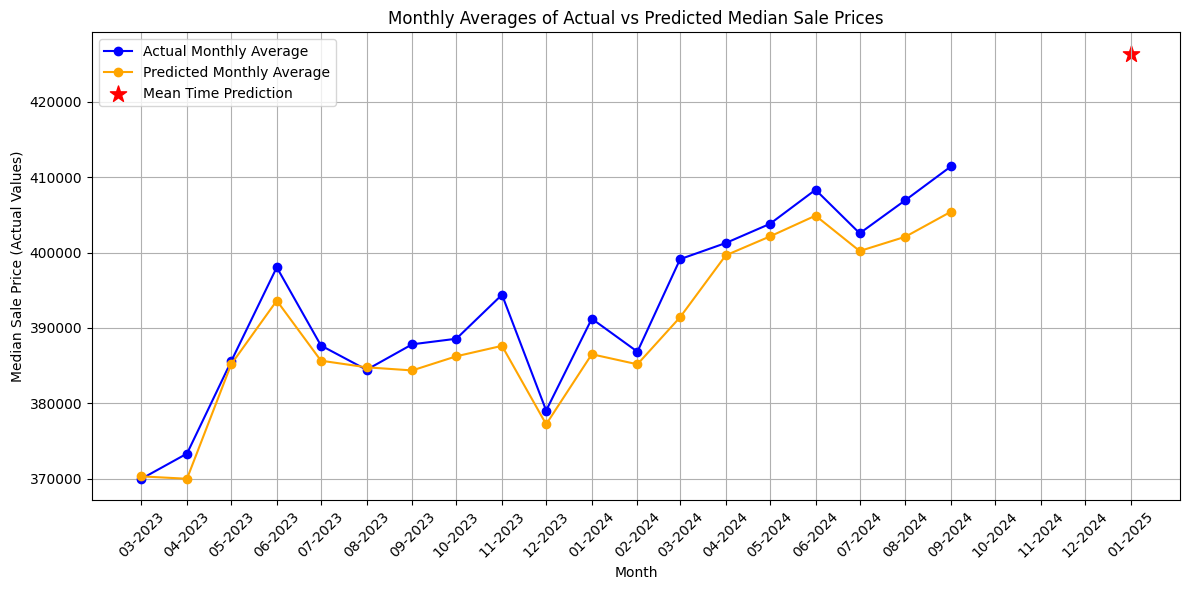

Plot saved as 'Resources/model_results.png'.


In [52]:
# Ensure the 'date' column is in datetime format
merged_results['date'] = pd.to_datetime(merged_results['date'])

# Group by month and calculate the average for Actual and Predicted
monthly_avg = merged_results.groupby(merged_results['date'].dt.to_period('M')).mean()

# Convert the Period Index back to datetime for plotting
monthly_avg.index = monthly_avg.index.to_timestamp()

# Use all training data months + future date range (10/2024-01/2025)
tick_dates = pd.date_range(start=monthly_avg.index.min(), end='2025-01-01', freq='MS')  # MS = Month Start

# Plot the monthly averages
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg['Actual'], label='Actual Monthly Average', marker='o', color='blue')
plt.plot(monthly_avg.index, monthly_avg['Predicted'], label='Predicted Monthly Average', marker='o', color='orange')

# Highlight the mean_time_prediction as a Red Star
mean_time_x = pd.Timestamp('2025-01-01') 
mean_time_y = mean_time_prediction[0]  
plt.scatter(mean_time_x, mean_time_y, color='red', label='Mean Time Prediction', s=150, marker='*') 

# Add titles and labels
plt.title('Monthly Averages of Actual vs Predicted Median Sale Prices')
plt.xlabel('Month')
plt.ylabel('Median Sale Price (Actual Values)')
plt.legend()
plt.grid()

# Add addtl xticks from original to include 10-2024 and 01-2025
plt.xticks(tick_dates, [date.strftime('%m-%Y') for date in tick_dates], rotation=45)

# Save the plot as an image
plt.savefig('Resources/test_results_plot_with_extended_ticks.png', format='png', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

print("Plot saved as 'Resources/model_results.png'.")

## Generate the top 25 feature columns and data from the datset to test model on future